Original setting

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pwd
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/M5/week5")
!ls
!pwd

/content
Detectron2_kitti_coco_cityscapes_change_LR.ipynb  output
Detectron2_kitti_coco_cityscapes.ipynb		  output_change_LR
Detectron2_kitti_coco_cityscapes_test.ipynb	  output_ori
exmaple_list.pkl				  training_validation.pkl
/content/drive/My Drive/Colab Notebooks/M5/week5


In [0]:
output_path = "./output_test/"

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Install detectron2

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-50n5u8x9
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-50n5u8x9
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275367 sha256=d2c38012f136728fd03cdb9223b2d4de99159f97a27ab2b8477a438c2bff9282
  Stored in directory: /tmp/pip-ephem-wheel-cache-v4kb7x8w/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software F

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


# import

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [0]:
import tensorflow
tensorflow.__version__

'1.15.2'

# Train on my dataset

generate the lines of training and validation, and save pkl.
if not, load pkl

In [0]:
# import os
# def read_gt_txt(gt_txt, gt_path):
#     gt_index_str = gt_txt.split(".")[0]
#     gt_file = "{}{}".format(gt_path, gt_txt)
#     gt = []
#     gt_one_frame = []
#     time_frame_last = 0
#     for line in open(gt_file):
#         fields = line.split()
#         time_frame = int(fields[0])

#         one_instance = [gt_index_str]
#         one_instance.extend(fields)

#         # print(instance)
#         if time_frame == time_frame_last:
#             gt_one_frame.append(one_instance)
#         else:
#             gt.append(gt_one_frame)
#             # if time_frame != len(gt):
#             #     #raise Exception("time_frame != len(gt)")
#             #     print("error")
#             gt_one_frame = []
#             gt_one_frame.append(one_instance)

#         time_frame_last = time_frame

#     if len(gt_one_frame) > 0:
#         gt.append(gt_one_frame)

#     return gt



# gt_path = "../../KITTI-MOTS/instances_txt/"
# gt_all = []
# for gt_id, gt_txt in enumerate(sorted(os.listdir(gt_path))):
#     gt = read_gt_txt(gt_txt, gt_path)
#     gt_all.extend(gt)


In [0]:
# from random import shuffle
# shuffle(gt_all)
# train_ratio = 0.8
# training = gt_all[:int(len(gt_all)*train_ratio)]
# validation = gt_all[-int(len(gt_all)*(1.0 - train_ratio) + 1):] 

# import pickle
# with open("training_validation.pkl", 'wb') as f:
#     pickle.dump([training, validation], f)
#     f.close()

load pkl

In [0]:
import pickle
with open("training_validation.pkl", 'rb') as p:
    training, validation = pickle.load(p)
    p.close()

In [0]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

import os
import numpy as np
import json
from detectron2.structures import BoxMode
from pycocotools.mask import toBbox, decode
import cv2


def register_from_dataset(dataset_path, dataset):

    dataset_dicts = []
    for idx, v in enumerate(dataset):
        instance_0 = v[0]
        record = {}

        filename = "{}/{}/{}.png".format(dataset_path, instance_0[0], instance_0[1].zfill(6))

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = int(instance_0[4])
        record["width"] = int(instance_0[5])

        objs = []
        for instance in v:
            # do like https://github.com/VisualComputingInstitute/mots_tools/blob/master/mots_common/io.py,
            # mask = {'size': [int(fields[3]), int(fields[4])], 'counts': fields[5].encode(encoding='UTF-8')}
            mask_rle = {'size': [int(instance[4]), int(instance[5])], 'counts': instance[6].encode(encoding='UTF-8')}
            box = toBbox(mask_rle)
            
            #convert rle to poly
            mask = decode(mask_rle)
            # https://github.com/facebookresearch/Detectron/issues/100  Sundrops
            # opencv 3.2
            # mask_new, contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            # before opencv 3.2
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []

            for contour in contours:
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            if len(segmentation) == 0:
                continue
            #End: convert rle to poly
            # print (segmentation)

            ori_class = int(instance[3])
            if ori_class == 1:
                transform_class = 0
            elif ori_class == 2:
                transform_class = 1
            else:
                # transform_class = 2
                continue

            obj = {
                "bbox": [box[0], box[1], box[0] + box[2], box[1] + box[3]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": segmentation,
                "category_id": transform_class,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_path = "../../KITTI-MOTS/training/image_02"
# thing_classes = ['Car', 'Pedestrian', 'DontCare']
thing_classes = ['Car', 'Pedestrian']

# g = lambda: register_from_dataset(dataset_path, training)
# g()





In [0]:
DatasetCatalog.register("KITTI_MOTS_training", lambda: register_from_dataset(dataset_path, training))
MetadataCatalog.get("KITTI_MOTS_training").set(thing_classes=thing_classes)
DatasetCatalog.register("KITTI_MOTS_val", lambda: register_from_dataset(dataset_path, validation))
MetadataCatalog.get("KITTI_MOTS_val").set(thing_classes=thing_classes)

KITTI_MOTS_metadata = MetadataCatalog.get("KITTI_MOTS_training")

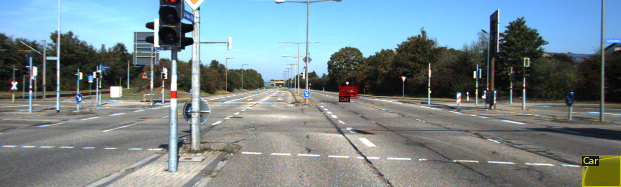

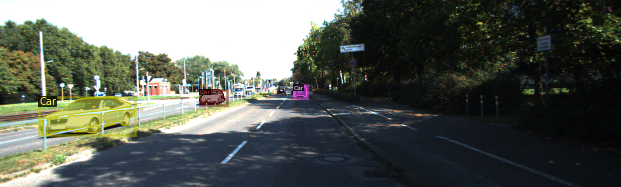

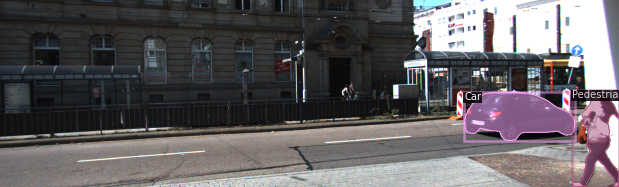

In [0]:
dataset_dicts = register_from_dataset(dataset_path, training)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=KITTI_MOTS_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [0]:
def filter_preds(preds, cat_mapping_coco_kitti):
    for pred in preds:
        pred['instances'] = [i for i in pred['instances'] if i['category_id'] in cat_mapping_coco_kitti.keys()]
        for instance in pred['instances']:
            instance['category_id'] = cat_mapping_coco_kitti[instance['category_id']]

    return preds

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

config_file = "Cityscapes/mask_rcnn_R_50_FPN.yaml"
coco_to_kitti_dict = {
        2: 0,
        0: 1,
    }

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)
cfg.DATASETS.TRAIN = ("KITTI_MOTS_training",)
cfg.DATASETS.TEST = ("KITTI_MOTS_val", )
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)



[03/29 16:49:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [0]:
evaluator = COCOEvaluator("KITTI_MOTS_val", cfg, False, output_dir=output_path)
val_loader = build_detection_test_loader(cfg, "KITTI_MOTS_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

preds = evaluator._predictions

filtered_preds = filter_preds(preds, coco_to_kitti_dict)
evaluator._predictions = filtered_preds

evaluator.evaluate()

WARNING [03/29 16:50:37 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'KITTI_MOTS_val'. Trying to convert it to COCO format ...
[03/29 16:50:37 d2.data.datasets.coco]: Converting dataset annotations in 'KITTI_MOTS_val' to COCO format ...)
[03/29 16:50:49 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/29 16:50:51 d2.data.datasets.coco]: Conversion finished, num images: 1586, num annotations: 7610
[03/29 16:50:51 d2.data.datasets.coco]: Caching annotations in COCO format: ./output_test/KITTI_MOTS_val_coco_format.json
[03/29 16:51:05 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    Car     | 5227         | Pedestrian | 2383         |
|            |              |            |              |
|   total    | 7610         |            |              |
[03/29 16:51:05 d2.data.common]: Serializing 1586 e

OrderedDict([('bbox',
              {'AP': 52.48429839372063,
               'AP-Car': 61.075075839832735,
               'AP-Pedestrian': 43.893520947608536,
               'AP50': 76.02072491774521,
               'AP75': 58.457872293383616,
               'APl': 67.45965874263968,
               'APm': 63.72357323133162,
               'APs': 34.22079019777779}),
             ('segm',
              {'AP': 44.1574925369452,
               'AP-Car': 58.43788487283381,
               'AP-Pedestrian': 29.877100201056585,
               'AP50': 72.18439480499146,
               'AP75': 45.337243431836924,
               'APl': 68.07292232264912,
               'APm': 53.94468689082241,
               'APs': 25.53901311355285})])